In [3]:
# smtplib 用于邮件的发信动作
import smtplib
# email 用于构建邮件内容
from email.mime.text import MIMEText
# 构建邮件头
from email.header import Header
import datetime

In [4]:
# 发信方的信息：发信邮箱，QQ 邮箱授权码
from_addr = '1580524241@qq.com'
password = 'xoyiazfnbpwjigbh'
# 收信方邮箱
to_addr = '389002792@qq.com'
# 发信服务器
smtp_server = 'smtp.qq.com'

In [5]:
# 邮箱正文内容，第一个参数为内容，第二个参数为格式(plain 为纯文本)，第三个参数为编码
strTime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
epoch = 1
email11 = '实验在第 ' + str(epoch) + 'epoch 结束\n' + '结束时间为：' + strTime
msg = MIMEText(email11, 'plain', 'utf-8')
# 邮件头信息
msg['From'] = Header('张三')  # 发送者
msg['To'] = Header('李四')  # 接收者
subject = 'Python SMTP 邮件测试'
msg['Subject'] = Header(subject, 'utf-8')  # 邮件主题

In [6]:
try:
    smtpobj = smtplib.SMTP_SSL(smtp_server)
    # 建立连接--qq邮箱服务和端口号（可百度查询）
    smtpobj.connect(smtp_server, 465)    
    # 登录--发送者账号和口令
    smtpobj.login(from_addr, password)   
    # 发送邮件
    smtpobj.sendmail(from_addr, to_addr, msg.as_string()) 
    print("邮件发送成功")
except smtplib.SMTPException:
    print("无法发送邮件")
finally:
    # 关闭服务器
    smtpobj.quit()

邮件发送成功


In [7]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image as img
import argparse

# file = 'X:\Directory\code\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_1'
# 解压缩，返回解压后的字典
def main():
    file = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_01'

    write_into_cifar10_poisondata(file)

def write_into_cifar10_poisondata(file):
    dict = poison_cifar10(file)
    fo = open(file, 'wb+')
    fo = fo.write(dict)
    fo.close()

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def poison_cifar10(file):
    label_dict = {
        0:'plane',
        1:'car',
        2:'bird',
        3:'cat',
        4:'deer',
        5:'dog',
        6:'frog',
        7:'horse',
        8:'ship',
        9:'truck'
    }
    
    # 第几张图片
    line_number = 0
    # 要poi几张
    pic_number = 1
    # 显示测试集图片
    dict = unpickle(file)
    data = dict.get("data")
    label = dict.get("labels")
    for line_number in range(pic_number):
        image_m = np.reshape(data[line_number], (3, 32, 32))
        image_label = label[line_number]
        r = image_m[0, :, :]
        g = image_m[1, :, :]
        b = image_m[2, :, :]
        img32 = np.array(cv.merge([r, g, b]))

        print(data.shape)

        # 扩充
        img224 = cv.resize(img32, (224, 224), 1)

        encode_start = 1

        if encode_start == 1:
            im_hidden, im_residual = ecode.encode(img224, line_number)
            
        img32_compress = cv.resize(im_hidden, (32, 32), 1)

        # python的数列范围是不取最后一个的
        print(img32_compress.shape)

        temp_r = np.reshape(img32_compress[:, :, 0], (1024, ))
        temp_g = np.reshape(img32_compress[:, :, 1], (1024, ))
        temp_b = np.reshape(img32_compress[:, :, 2], (1024, ))

        dict.get("data")[line_number,0:1024] = temp_r 
        dict.get("data")[line_number,1024:2048] = temp_g
        dict.get("data")[line_number,2048:3072] = temp_b

        backout_r = dict.get("data")[line_number,0:1024].reshape(32, 32)
        backout_g = dict.get("data")[line_number,1024:2048].reshape(32, 32)
        backout_b = dict.get("data")[line_number,2048:3072].reshape(32, 32)
        img32_backout = np.array(cv.merge([backout_r, backout_g, backout_b]))
        
        # plt.ion()
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(img32)   # cifar10 原图
        plt.subplot(1, 3, 2)
        plt.imshow(img32_backout)   # cifar10 回传后提出来看有没有进去
        plt.title(label_dict[label[line_number]])
        plt.subplot(1, 3, 3)
        plt.imshow(img224)  # cifar10 扩充224图
    plt.show()
    return dict

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\code\\code_xwd\\Durable-Federated-Learning-Backdoor\\FL_Backdoor_CV\\data\\cifar-10-batches-py\\data_batch_01'

两张图片不一样


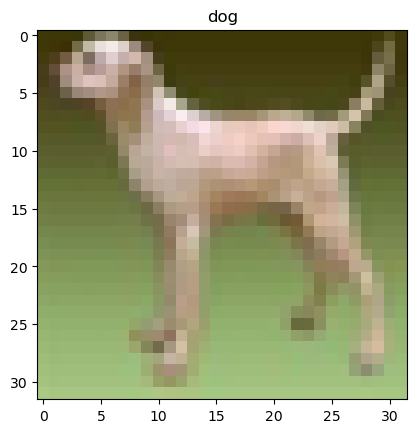

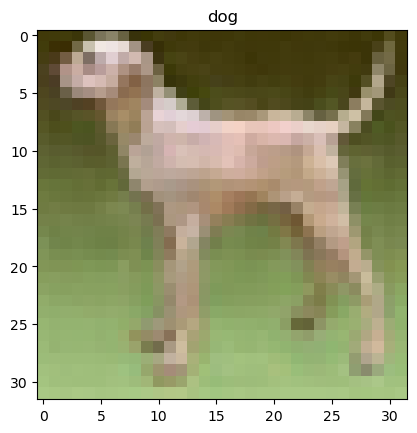

In [15]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image
from PIL import ImageChops
import argparse

file = '..\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_3'
file_poison = '..\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_3_poison'

poi_index = open('index.txt', 'a+')

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def read_pic(dict, line_number):
    data = dict.get("data")
    label = dict.get("labels")
    image_m = np.reshape(data[line_number], (3, 32, 32))
    image_label = label[line_number]
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    return img32, image_label

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
# 第几张图片
line_number = 9999
# 显示测试集图片
dict = unpickle(file)
dict_poison = unpickle(file_poison)
img32, image_label = read_pic(dict, line_number)
img32_poison, image_label_poison = read_pic(dict_poison, line_number)

# poi_index.write(str(line_number) + '  ' + label_dict[image_label_poison] + '\n')

plt.figure(frameon=False)
plt.title(label_dict[image_label])
plt.imshow(img32)
plt.savefig('img32org.png')
plt.figure(frameon=False)
plt.title(label_dict[image_label_poison])
plt.imshow(img32_poison)
plt.savefig('img32poi.png')

image1 = cv.imread("img32org.png")
image2 = cv.imread("img32poi.png")
difference = cv.subtract(image1, image2)
result = not np.any(difference) #if difference is all zeros it will return False

if result is True:
    print("两张图片一样")
else:
    cv.imwrite("result.jpg", difference)
    print ("两张图片不一样")

poi_index.close()
plt.show()